# Importing Necessary Libraries

In [1]:
import numpy as np 
import pandas as pd 
import os 
import matplotlib.pyplot as plt

In [2]:
import random
from IPython.display import Image
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [3]:
import causalml
from causalml.dataset import make_uplift_classification
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.


# Definition of Functions

## 1. Error Function

In [4]:
def f(row):
    if row['treatment_group_key'] == row['predT'] and row['predY'] >= row['y']:
        val = 1
    elif row['treatment_group_key'] != row['predT'] and row['predY'] < row['y']:
        val = 1
    else:
        val = 0
    return val

## 2. Adaboost Uplift Algorithm

In [5]:
# Source: CausalML, but adapted
def predict(self, X, full_output=True):
        p_hat_optimal = []
        treatment_optimal = []
        pred_nodes = {}
        upliftScores = []
        for xi in range(len(X)):
            pred_leaf, upliftScore = self.classify(X[xi], self.fitted_uplift_tree, dataMissing=False)
            # Predict under uplift optimal treatment
            opt_treat = max(pred_leaf, key=pred_leaf.get)
            p_hat_optimal.append(pred_leaf[opt_treat])
            treatment_optimal.append(opt_treat)
            if full_output:
                if xi == 0:
                    for key_i in pred_leaf:
                        pred_nodes[key_i] = [pred_leaf[key_i]]
                else:
                    for key_i in pred_leaf:
                        pred_nodes[key_i].append(pred_leaf[key_i])
                upliftScores.append(upliftScore)
        treatment_optimal = pd.DataFrame(treatment_optimal)
        pred_nodes = pd.DataFrame(pred_nodes )
        New = pd.concat([treatment_optimal,pred_nodes],axis=1)
        New = New.rename({0:"recommended_treatment"},axis=1)
        
        if full_output:
            return New

        else:
            return New

In [6]:
# Source: CausalML, but adapted
def predictFor(self, X, full_output=False):
        df_res = pd.DataFrame()
        y_pred_ensemble = dict()
        y_pred_list = np.zeros((X.shape[0], len(self.classes_)))

        # Make prediction by each tree
        for tree_i in range(len(self.uplift_forest)):

            _, _, _, y_pred_full = self.uplift_forest[tree_i].predict(X=X, full_output=True)

            if tree_i == 0:
                for treatment_group in y_pred_full:
                    y_pred_ensemble[treatment_group] = (
                        np.array(y_pred_full[treatment_group]) / len(self.uplift_forest)
                    )
            else:
                for treatment_group in y_pred_full:
                    y_pred_ensemble[treatment_group] = (
                        np.array(y_pred_ensemble[treatment_group])
                        + np.array(y_pred_full[treatment_group]) / len(self.uplift_forest)
                    )

        # Summarize results into dataframe
        for treatment_group in y_pred_ensemble:
            df_res[treatment_group] = y_pred_ensemble[treatment_group]

        df_res['recommended_treatment'] = df_res.apply(np.argmax, axis=1)

        # Calculate delta
        delta_cols = []
        for treatment_group in y_pred_ensemble:
            if treatment_group != self.control_name:
                delta_cols.append('delta_%s' % (treatment_group))
                df_res['delta_%s' % (treatment_group)] = df_res[treatment_group] - df_res[self.control_name]
                # Add deltas to results list
                y_pred_list[:, self.classes_[treatment_group]] = df_res['delta_%s' % (treatment_group)].values
        df_res['max_delta'] = df_res[delta_cols].max(axis=1)

        return df_res

In [241]:
def adaboost_cts(data,test, M):
    global betaList
    betaList=[]
    global models
    models = []
    n_train = len(data)
    global PreY
    PreY = []
    global Total
    Total = []
    global betan
    betan = pd.DataFrame(pd.np.empty((len(test), 1)))
    global output


    
    for i in range(M):
        while i==0:
            input = data.copy()
            # Add weights
            input["weight"] = np.ones(len(input))/len(input)
            # Calculate uplift based on CTS
            uplift_model = UpliftTreeClassifier(max_depth = 4, min_samples_leaf = 10, min_samples_treatment = 100, 
                                    n_reg = 1, evaluationFunction='CTS', control_name='No Discount')

            uplift_model.fit(input[x_names].values,
                 treatment=input['treatment_group_key'].values,
                 y=input['y'].values)

            # Extract predictions for training data
            x_pred = np.transpose(pd.DataFrame(uplift_model.predict(input[x_names].values)))
            
            # Add predictions to original data frame
            input = pd.concat([input.reset_index(drop='True'),x_pred.reset_index(drop='True')],axis=1)
            input = input.rename({0: 'predT', 1: 'predY'}, axis="columns")
        
            # Make and save predictions on test set
            y_pred = predict(uplift_model,test[x_names].values)
            column = y_pred[["No Discount","P_25","P_50","P_20","P_75"]]
            y_pred = y_pred.assign(max_value = column.max(1))
            y_pred["Uplift"]=y_pred.max_value - y_pred["No Discount"]
            y_pred = y_pred.drop(columns=["No Discount","P_25","P_50","P_20","P_75","max_value"])
            PreY.append(y_pred)
        
            # Calculate error of each observation (0 or 1)
            errors = input.apply(f, axis=1)

            # Model error
            e = ((errors*input.weight).sum())/(input.weight.sum()) # check that one again
            # Calculate weight of the whole model
            beta = np.exp(-3*e)
            # Add model weight to list
            betaList.append(beta)
            betan[0] = beta
            y_pred["beta"]=betan
            y_pred = y_pred[["beta","recommended_treatment","Uplift"]]
            Total.append(y_pred)

            # Change weights for each data point
            for i in range(len(input)):
                if errors[i] == 1: input.weight[i] = input.weight[i]* (1-0.5*beta)**-1
                else: input.weight[i]  = input.weight[i] * beta
            
            # Drop predictions columns so that they can be added in the next iteration again
            input = input.drop(columns=["predT","predY"])
            
            # Create new variable
            output = input.copy()
            
            
        while 0 < i < M :
            input = output.sample(weights = output.weight, n=len(output), replace=True, random_state=111)
            input.weight = np.ones(len(input))/len(input)
            uplift_model = UpliftTreeClassifier(max_depth = 4, min_samples_leaf = 10, min_samples_treatment = 10, 
                                    n_reg = 1, evaluationFunction='CTS', control_name='No Discount')

            uplift_model.fit(input[x_names].values,
                 treatment=input['treatment_group_key'].values,
                 y=input['y'].values)

            x_pred = np.transpose(pd.DataFrame(uplift_model.predict(input[x_names].values)))
            
            input = pd.concat([input.reset_index(drop='True'),x_pred.reset_index(drop='True')],axis=1)
            input = input.rename({0: 'predT', 1: 'predY'}, axis="columns")
            
            # Make and save predictions on test set
            y_pred = predict(uplift_model,test[x_names].values)
            column = y_pred[["No Discount","P_25","P_50","P_20","P_75"]]
            y_pred = y_pred.assign(max_value = column.max(1))
            y_pred["Uplift"]=y_pred.max_value - y_pred["No Discount"]
            y_pred = y_pred.drop(columns=["No Discount","P_25","P_50","P_20","P_75","max_value"])
            PreY.append(y_pred)
            
            errors = input.apply(f, axis=1)
           
            
            e = ((errors*input.weight).sum())/input.weight.sum() 
            beta = np.exp(-3*e)
            betaList.append(beta)
            betan[0] = beta
            y_pred["beta"]=betan
            y_pred = y_pred[["beta","recommended_treatment","Uplift"]]
            Total.append(y_pred)
        
        
            
            for i in range(len(input)):
                if errors[i] == 1: input.weight[i] = input.weight[i]* (1-0.5*beta)**-1
                else: input.weight[i]  = input.weight[i] * beta
        
            input =input.drop(columns=["predT","predY"])
            output = input.copy()

## 3. Recommended Treatment (Uplift AdaBoost)

In [8]:
def get_max_treatment(*args):
    global results
    results = []
    global df_all
    df_all = []
    for a in args:
       df_all.append(a)
    
    df_all = pd.concat(df_all)
    nrows = len(np.unique(df_all.index.to_list()))
    
    for i in range(nrows):
        results.append(df_all.loc[i].groupby(['recommended_treatment']).sum().sort_values(by=['beta'], ascending=False).index.to_list()[0])
        
    return results


## 4. Predicted Outcome under Optimal Treatment (Uplift AdaBoost)

In [9]:
def get_mean_y(df_all,results):
    global mean_y
    li = []
    mean_y = []
    #results = results.predT.to_list()
    for i in range(len(results)):
        d = df_all.loc[i][df_all.loc[i].recommended_treatment == results[i]]
        li.append(d)
        mean_y.append(li[i].Uplift.mean())
    
    mean_y = pd.DataFrame(mean_y)
    
    return mean_y

# Adaboost Uplift with Shoe Data Set

## 1. Loading the Data & Descriptive Statistics

In [207]:
file = "/Users/jessicastrobel/Desktop/Uni/Humboldt Uni/Applied Predictive Analytics/Data from Robin/data.csv"
shoedat = pd.read_csv(file)
dat = shoedat.copy()
dat.describe()

,campaignMov,checkoutAmount,lastSessionTimestamp,lastConversionTimestamp,treatmentGroup,MT_P_20,MT_P_25,MT_P_50,MT_P_75,MT_Control
count,133595.0,133595.000000,6.487100e+04,1.241300e+04,133595.000000,133595.000000,133595.000000,133595.000000,133595.000000,133595.000000
mean,0.0,369.815442,1.491698e+09,1.518005e+09,0.748524,0.083446,0.005479,0.584528,0.075070,0.251476
std,0.0,1873.830680,3.096297e+08,2.410816e+08,0.433863,0.276557,0.073819,0.492805,0.263506,0.433863
min,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,1.544569e+09,1.549795e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.0,0.000000,1.557262e+09,1.557576e+09,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.0,0.000000,1.563882e+09,1.562430e+09,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,0.0,74530.000000,1.574170e+09,1.574078e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [209]:
dat.columns.values

array(['campaignMov', 'checkoutAmount', 'converted', 'dropOff',
       'confirmed', 'aborted', 'isMobile', 'zipCode', 'hadCartAdd',
       'clientKnown', 'lastSessionTimestamp', 'lastConversionTimestamp',
       'initScreenType', 'channel', 'treatmentGroup', 'multi_treat',
       'MT_P_20', 'MT_P_25', 'MT_P_50', 'MT_P_75', 'MT_Control'],
      dtype=object)

In [210]:
dat.channel.value_counts()

SEARCH         66535
DIRECT         38238
INTERNAL       20306
AFFILIATE       3921
RETARGETING     2334
PAID            1747
SOCIAL           355
EMAIL            159
Name: channel, dtype: int64

In [211]:
dat.multi_treat.value_counts()

P_50    78090
0       33596
P_20    11148
P_75    10029
P_25      732
Name: multi_treat, dtype: int64

In [212]:
pd.crosstab(dat.multi_treat, dat.converted)

converted,False,True
multi_treat,,
0,31307,2289
P_20,10315,833
P_25,682,50
P_50,72793,5297
P_75,9263,766


In [213]:
dat.groupby([dat.multi_treat]).sum()

,campaignMov,checkoutAmount,converted,dropOff,confirmed,aborted,isMobile,hadCartAdd,clientKnown,lastSessionTimestamp,lastConversionTimestamp,treatmentGroup,MT_P_20,MT_P_25,MT_P_50,MT_P_75,MT_Control
multi_treat,,,,,,,,,,,,,,,,,
0,0,12208169,2289.0,4557.0,0.0,4.0,27718.0,6082.0,16235.0,2.422358e+13,4.732768e+12,0,0,0,0,0,33596
P_20,0,4871826,833.0,1451.0,426.0,5621.0,8370.0,2044.0,5184.0,7.901663e+12,1.475061e+12,11148,11148,0,0,0,0
P_25,0,354214,50.0,93.0,59.0,411.0,534.0,127.0,317.0,4.857039e+11,9.357245e+10,732,0,732,0,0,0
P_50,0,27767620,5297.0,9836.0,3145.0,39167.0,64762.0,14173.0,37752.0,5.613446e+13,1.086307e+13,78090,0,0,78090,0,0
P_75,0,4203665,766.0,921.0,1515.0,3498.0,8781.0,2117.0,5383.0,8.022505e+12,1.678521e+12,10029,0,0,0,10029,0


## 2. Preparation of the Data

In [214]:
# Change the amount of money from cents to euros
dat.checkoutAmount = dat.checkoutAmount.values/100
dat.describe()

,campaignMov,checkoutAmount,lastSessionTimestamp,lastConversionTimestamp,treatmentGroup,MT_P_20,MT_P_25,MT_P_50,MT_P_75,MT_Control
count,133595.0,133595.000000,6.487100e+04,1.241300e+04,133595.000000,133595.000000,133595.000000,133595.000000,133595.000000,133595.000000
mean,0.0,3.698154,1.491698e+09,1.518005e+09,0.748524,0.083446,0.005479,0.584528,0.075070,0.251476
std,0.0,18.738307,3.096297e+08,2.410816e+08,0.433863,0.276557,0.073819,0.492805,0.263506,0.433863
min,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,1.544569e+09,1.549795e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.0,0.000000,1.557262e+09,1.557576e+09,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.0,0.000000,1.563882e+09,1.562430e+09,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,0.0,745.300000,1.574170e+09,1.574078e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [215]:
dat['multi_treat'] = np.where(dat['multi_treat'] == "0", "No Discount", dat['multi_treat'])
dat.head()

,campaignMov,checkoutAmount,converted,dropOff,confirmed,aborted,isMobile,zipCode,hadCartAdd,clientKnown,...,lastConversionTimestamp,initScreenType,channel,treatmentGroup,multi_treat,MT_P_20,MT_P_25,MT_P_50,MT_P_75,MT_Control
0,0,0.0,False,True,False,True,True,86405,False,True,...,NaN,home,SEARCH,1,P_50,0,0,1,0,0
1,0,0.0,False,False,False,False,True,78532,False,False,...,NaN,home,AFFILIATE,0,No Discount,0,0,0,0,1
2,0,0.0,False,False,False,False,True,10369,False,True,...,NaN,product,AFFILIATE,1,P_50,0,0,1,0,0
3,0,0.0,False,False,False,False,True,86150,False,True,...,NaN,product,DIRECT,0,No Discount,0,0,0,0,1
4,0,0.0,False,False,False,False,True,32549,False,False,...,NaN,overview,DIRECT,0,No Discount,0,0,0,0,1


In [216]:
dat = dat.rename({"multi_treat": 'treatment_group_key'}, axis="columns")
dat = dat[['hadCartAdd','clientKnown','initScreenType',"channel","lastConversionTimestamp","lastSessionTimestamp",'treatment_group_key',"checkoutAmount","converted"]]
dat = dat.rename({"checkoutAmount": 'y'}, axis="columns")

In [217]:
dat=dat.fillna(0)
dat.head()

,hadCartAdd,clientKnown,initScreenType,channel,lastConversionTimestamp,lastSessionTimestamp,treatment_group_key,y,converted
0,False,True,home,SEARCH,0.0,1.562230e+09,P_50,0.0,False
1,False,False,home,AFFILIATE,0.0,0.000000e+00,No Discount,0.0,False
2,False,True,product,AFFILIATE,0.0,1.560770e+09,P_50,0.0,False
3,False,True,product,DIRECT,0.0,1.561925e+09,No Discount,0.0,False
4,False,False,overview,DIRECT,0.0,0.000000e+00,No Discount,0.0,False


In [218]:
dat.describe()

,lastConversionTimestamp,lastSessionTimestamp,y
count,1.335950e+05,1.335950e+05,133595.000000
mean,1.410456e+08,7.243378e+08,3.698154
std,4.467834e+08,7.761342e+08,18.738307
min,0.000000e+00,0.000000e+00,0.000000
25%,0.000000e+00,0.000000e+00,0.000000
50%,0.000000e+00,0.000000e+00,0.000000
75%,0.000000e+00,1.556815e+09,0.000000
max,1.574078e+09,1.574170e+09,745.300000


In [219]:
# Dummy coding of some of the variables
dat = pd.get_dummies(data = dat, columns=['initScreenType',"channel","hadCartAdd","clientKnown"])
x_names = dat.keys()
x_names = x_names.drop(["y","treatment_group_key"])
x_names

Index(['lastConversionTimestamp', 'lastSessionTimestamp', 'converted',
       'initScreenType_about', 'initScreenType_account',
       'initScreenType_basket', 'initScreenType_billing',
       'initScreenType_checkout', 'initScreenType_home',
       'initScreenType_order', 'initScreenType_other',
       'initScreenType_overview', 'initScreenType_payment',
       'initScreenType_product', 'initScreenType_sale',
       'initScreenType_search', 'initScreenType_shipping', 'channel_AFFILIATE',
       'channel_DIRECT', 'channel_EMAIL', 'channel_INTERNAL', 'channel_PAID',
       'channel_RETARGETING', 'channel_SEARCH', 'channel_SOCIAL',
       'hadCartAdd_False', 'hadCartAdd_True', 'clientKnown_False',
       'clientKnown_True'],
      dtype='object')

## 3. Building the Model

In [220]:
# Split data to training and testing samples for model validation (next section)
dat_train, dat_test= train_test_split(dat, test_size=0.2, random_state=111)
dat_train.head()

,lastConversionTimestamp,lastSessionTimestamp,treatment_group_key,y,converted,initScreenType_about,initScreenType_account,initScreenType_basket,initScreenType_billing,initScreenType_checkout,...,channel_EMAIL,channel_INTERNAL,channel_PAID,channel_RETARGETING,channel_SEARCH,channel_SOCIAL,hadCartAdd_False,hadCartAdd_True,clientKnown_False,clientKnown_True
74769,0.000000e+00,0.000000e+00,P_50,0.0,False,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
12259,1.560153e+09,1.559317e+09,P_50,0.0,False,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1
2625,0.000000e+00,1.556704e+09,P_50,0.0,False,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
104537,0.000000e+00,0.000000e+00,No Discount,0.0,False,0,0,0,0,0,...,0,0,0,0,1,0,1,0,1,0
60913,0.000000e+00,1.544359e+09,P_50,0.0,False,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1


In [242]:
# Run the model
adaboost_cts(data=dat_train, test=dat_test, M=8)

In [243]:
# Overview over betas of each round
betaList

[0.6921778504817854,
 0.6857957622571197,
 0.32817537994902046,
 0.5244761284763606,
 0.49919503313932057,
 0.4433934946800732,
 0.32611839816485044,
 0.4414437694055415]

In [22]:
# You have to choose here the one similar to the "M" chosen in the adaboost formula. 

In [309]:
# # 1 round
# d1 = Total[0]

In [310]:
# # 3 rounds
# d1 = Total[0]
# d2 = Total[1]
# d3 = Total[2]
# results=get_max_treatment(d1,d2,d3)

In [311]:
# 6 rounds
#d1 = Total[0]
#d2 = Total[1]
#d3 = Total[2]
#d4 = Total[3]
#d5 = Total[4]
#d6 = Total[5]
#results=get_max_treatment(d1,d2,d3,d4,d5,d6)

In [244]:
# # 8 rounds
d1 = Total[0]
d2 = Total[1]
d3 = Total[2]
d4 = Total[3]
d5 = Total[4]
d6 = Total[5]
d7 = Total[6]
d8 = Total[7]

results=get_max_treatment(d1,d2,d3,d4,d5,d6,d7,d8)

In [313]:
# # 12 rounds
# d1 = Total[0]
# d2 = Total[1]
# d3 = Total[2]
# d4 = Total[3]
# d5 = Total[4]
# d6 = Total[5]
# d7 = Total[6]
# d8 = Total[7]
# d9 = Total[8]
# d10 = Total[9]
# d11= Total[10]
# d12= Total[11]
# result = get_max_treatment(d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12)

In [89]:
# # 15 rounds
#d1 = Total[0]
#d2 = Total[1]
#d3 = Total[2]
#d4 = Total[3]
#d5 = Total[4]
#d6 = Total[5]
#d7 = Total[6]
#d8 = Total[7]
#d9 = Total[8]
#d10 = Total[9]
#d11= Total[10]
#d12= Total[11]
#d13 = Total[12]
#d14= Total[13]
#d15= Total[14]

#result = get_max_treatment(d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14,d15)

In [245]:
# Get the predicted y value per person
get_mean_y(df_all,results)

,0
0,6.894187
1,13.608724
2,7.271233
3,4.551870
4,9.247540
...,...
26714,13.010594
26715,11.849709
26716,11.408027
26717,4.009383


In [246]:
# Just to see predictions of one person (VALUES GETTING BIGGER AND BIGGER EACH ROUND...)
df_all.loc[29]

,beta,recommended_treatment,Uplift
29,0.692178,P_20,1.403098
29,0.685796,P_25,0.000000
29,0.328175,P_50,1.798908
29,0.524476,No Discount,0.000000
29,0.499195,P_75,8.271704
29,0.443393,No Discount,0.000000
29,0.326118,P_25,13.655610
29,0.441444,P_25,0.000000


In [247]:
mean_y

,0
0,6.894187
1,13.608724
2,7.271233
3,4.551870
4,9.247540
...,...
26714,13.010594
26715,11.849709
26716,11.408027
26717,4.009383


# Evaluation of the Model

## 1. Overview of Results of Adaboost Uplift

In [248]:
# Create dataframe that contains all the results
table_uplift = pd.concat([pd.DataFrame(results),pd.DataFrame(mean_y)],axis=1)
table_uplift.columns= ["Predicted treatment","Predicted y"]
table_uplift

,Predicted treatment,Predicted y
0,P_20,6.894187
1,P_25,13.608724
2,P_20,7.271233
3,P_25,4.551870
4,P_20,9.247540
...,...,...
26714,P_25,13.010594
26715,P_75,11.849709
26716,P_25,11.408027
26717,P_25,4.009383


In [249]:
dat_test.treatment_group_key

18397            P_50
61127     No Discount
131186           P_20
19039            P_50
44143            P_50
             ...     
108691           P_50
36359            P_50
124953           P_20
78801     No Discount
14658     No Discount
Name: treatment_group_key, Length: 26719, dtype: object

In [250]:
new1 = dat_test.y.reset_index(drop=True)
new2 = dat_test.treatment_group_key.reset_index(drop=True)

## 2. Benchmark Models

### Conctextual Treatment Selection (CTS)

In [63]:
# Train uplift tree
uplift_model1 = UpliftRandomForestClassifier(n_estimators=10,max_depth = 4, min_samples_leaf = 10, 
                                             min_samples_treatment = 100, n_reg = 1, evaluationFunction='CTS', 
                                             control_name ='No Discount',
                                             random_state=50)

uplift_model1.fit(dat_train[x_names].values,
                 treatment=dat_train['treatment_group_key'].values,
                 y=dat_train.y.values)
uplift_model1


In [64]:
# Predict using the build CTS Model
predictions = predictFor(uplift_model1,dat_test[x_names].values)
predictions

,P_25,No Discount,P_75,P_20,P_50,recommended_treatment,delta_P_25,delta_P_75,delta_P_20,delta_P_50,max_delta
0,2.884481,3.129745,3.102666,3.809020,3.149865,3,-0.245265,-0.027079,0.679275,0.020120,0.679275
1,3.750257,3.551312,4.070228,4.283898,3.539107,3,0.198944,0.518916,0.732586,-0.012205,0.732586
2,3.480843,3.645071,3.714344,4.311932,3.511467,3,-0.164228,0.069272,0.666860,-0.133604,0.666860
3,2.513431,3.252722,3.305358,4.056874,3.133708,3,-0.739291,0.052636,0.804152,-0.119014,0.804152
4,3.126133,3.532689,3.642013,4.353868,3.497931,3,-0.406556,0.109324,0.821178,-0.034759,0.821178
...,...,...,...,...,...,...,...,...,...,...,...
26714,4.860736,3.680925,4.244984,4.307008,3.899091,0,1.179811,0.564059,0.626083,0.218166,1.179811
26715,5.084657,3.442675,4.271951,3.737018,3.328577,0,1.641982,0.829276,0.294343,-0.114098,1.641982
26716,2.597403,3.276708,3.580473,4.071346,3.208504,3,-0.679305,0.303766,0.794638,-0.068204,0.794638
26717,3.987905,3.365244,3.456842,4.030729,3.178204,3,0.622661,0.091597,0.665484,-0.187040,0.665484


In [65]:
CTS_tr_map = {0:'P_75',1:'No Discount',2:'P_25',3:'P_20',4:'P_50'}
predictions = predictions.replace({"recommended_treatment": CTS_tr_map})
Pred_CTS = pd.DataFrame(predictions, columns=["recommended_treatment","max_delta"])
Pred_CTS = Pred_CTS.rename({"max_delta":"Uplift CTS"},axis=1)
Pred_CTS

,recommended_treatment,Uplift CTS
0,P_20,0.679275
1,P_20,0.732586
2,P_20,0.666860
3,P_20,0.804152
4,P_20,0.821178
...,...,...
26714,P_75,1.179811
26715,P_75,1.641982
26716,P_20,0.794638
26717,P_20,0.665484


In [66]:
treat = Pred_CTS.recommended_treatment
ycts = Pred_CTS["Uplift CTS"]

### Separate Model Approach (SMA)

In [67]:
# Separate control and the different treatment groups
Control = dat_train[dat_train["treatment_group_key"]=='No Discount']
Tr1 = dat_train[dat_train["treatment_group_key"]=='P_20'] 
Tr2 = dat_train[dat_train["treatment_group_key"]=='P_25'] 
Tr3 = dat_train[dat_train["treatment_group_key"]=='P_50'] 
Tr4 = dat_train[dat_train["treatment_group_key"]=='P_75'] 

In [130]:
# Set the parameters by cross-validation
tuned_parameters = {'n_estimators': [30, 50, 100], 'max_depth': [None, 1, 2, 3], 'min_samples_split': [1, 2, 3]}

clf0 = GridSearchCV(ensemble.RandomForestRegressor(random_state=1), tuned_parameters, cv=5, 
                   n_jobs=-1, verbose=1)
clf1 = GridSearchCV(ensemble.RandomForestRegressor(random_state=1), tuned_parameters, cv=5, 
                   n_jobs=-1, verbose=1)
clf2 = GridSearchCV(ensemble.RandomForestRegressor(random_state=1), tuned_parameters, cv=5, 
                   n_jobs=-1, verbose=1)
clf3 = GridSearchCV(ensemble.RandomForestRegressor(random_state=1), tuned_parameters, cv=5, 
                   n_jobs=-1, verbose=1)
clf4 = GridSearchCV(ensemble.RandomForestRegressor(random_state=1), tuned_parameters, cv=5, 
                   n_jobs=-1, verbose=1)

clf0 = clf0.fit(Control[x_names], Control.y.values)
clf1 = clf1.fit(Tr1[x_names], Tr1.y.values)
clf2 = clf2.fit(Tr2[x_names], Tr2.y.values)
clf3 = clf3.fit(Tr3[x_names], Tr3.y.values)
clf4 = clf4.fit(Tr3[x_names], Tr3.y.values)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   51.5s finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   13.8s finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    8.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.1min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.1min finished


In [131]:
# Control
pr0 = pd.DataFrame(clf0.predict(dat_test[x_names].values))
# Tr1
pr1 = pd.DataFrame(clf1.predict(dat_test[x_names].values))
# Tr2
pr2 = pd.DataFrame(clf2.predict(dat_test[x_names].values))
# Tr3
pr3 = pd.DataFrame(clf3.predict(dat_test[x_names].values))
# Tr4
pr4 = pd.DataFrame(clf4.predict(dat_test[x_names].values))

In [132]:
SMA = pd.concat([pr0,pr1,pr2,pr3,pr4],axis=1)
SMA.columns = ["No_Discount","P_20","P_25","P_50","P_75"]
SMA['recommended_treat_SMA'] = SMA.idxmax(axis=1)
SMA

,No_Discount,P_20,P_25,P_50,P_75,recommended_treat_SMA
0,0.0,0.0,0.0,0.0,0.0,No_Discount
1,0.0,0.0,0.0,0.0,0.0,No_Discount
2,0.0,0.0,0.0,0.0,0.0,No_Discount
3,0.0,0.0,0.0,0.0,0.0,No_Discount
4,0.0,0.0,0.0,0.0,0.0,No_Discount
...,...,...,...,...,...,...
26714,0.0,0.0,0.0,0.0,0.0,No_Discount
26715,0.0,0.0,0.0,0.0,0.0,No_Discount
26716,0.0,0.0,0.0,0.0,0.0,No_Discount
26717,0.0,0.0,0.0,0.0,0.0,No_Discount


In [133]:
column = SMA[["No_Discount","P_25","P_50","P_20","P_75"]]
SMA = SMA.assign(max_value = column.max(1))
SMA["Uplift SMA"]=SMA.max_value - SMA["No_Discount"]
SMA = SMA.drop(columns=["No_Discount","P_25","P_50","P_20","P_75","max_value"])
SMA

,recommended_treat_SMA,Uplift SMA
0,No_Discount,0.0
1,No_Discount,0.0
2,No_Discount,0.0
3,No_Discount,0.0
4,No_Discount,0.0
...,...,...
26714,No_Discount,0.0
26715,No_Discount,0.0
26716,No_Discount,0.0
26717,No_Discount,0.0


## 3. Comparison of the Models

In [251]:
# Start building a table to have an overview
table_uplift = pd.concat([table_uplift,ycts,treat,SMA,new1,new2], axis=1)

table_uplift = table_uplift.head(26719)
table_uplift

,Predicted treatment,Predicted y,Uplift CTS,recommended_treatment,recommended_treat_SMA,Uplift SMA,y,treatment_group_key
0,P_20,6.894187,0.679275,P_20,No_Discount,0.0,0.0,P_50
1,P_25,13.608724,0.732586,P_20,No_Discount,0.0,0.0,No Discount
2,P_20,7.271233,0.666860,P_20,No_Discount,0.0,0.0,P_20
3,P_25,4.551870,0.804152,P_20,No_Discount,0.0,0.0,P_50
4,P_20,9.247540,0.821178,P_20,No_Discount,0.0,0.0,P_50
...,...,...,...,...,...,...,...,...
26714,P_25,13.010594,1.179811,P_75,No_Discount,0.0,0.0,P_50
26715,P_75,11.849709,1.641982,P_75,No_Discount,0.0,0.0,P_50
26716,P_25,11.408027,0.794638,P_20,No_Discount,0.0,0.0,P_20
26717,P_25,4.009383,0.665484,P_20,No_Discount,0.0,0.0,No Discount


In [252]:
table_uplift.columns = ["PredictedTreatment","Predicted Uplift",
                        "CTS Uplift","CTS treatment",
                        "SMA treatment","SMA Uplift",
                        "Real Spending","RealTreatment"]

#table_uplift.columns = ["PredictedTreatment","Predicted Uplift",
#                         "CTS Uplift","CTS treatment",
#                         "SMA Uplift",
#                         "Real Spending","RealTreatment"]
table_uplift

,PredictedTreatment,Predicted Uplift,CTS Uplift,CTS treatment,SMA treatment,SMA Uplift,Real Spending,RealTreatment
0,P_20,6.894187,0.679275,P_20,No_Discount,0.0,0.0,P_50
1,P_25,13.608724,0.732586,P_20,No_Discount,0.0,0.0,No Discount
2,P_20,7.271233,0.666860,P_20,No_Discount,0.0,0.0,P_20
3,P_25,4.551870,0.804152,P_20,No_Discount,0.0,0.0,P_50
4,P_20,9.247540,0.821178,P_20,No_Discount,0.0,0.0,P_50
...,...,...,...,...,...,...,...,...
26714,P_25,13.010594,1.179811,P_75,No_Discount,0.0,0.0,P_50
26715,P_75,11.849709,1.641982,P_75,No_Discount,0.0,0.0,P_50
26716,P_25,11.408027,0.794638,P_20,No_Discount,0.0,0.0,P_20
26717,P_25,4.009383,0.665484,P_20,No_Discount,0.0,0.0,No Discount


In [253]:
# make all P_X to "T" and all No Discount to "C"
tr_map = {"P_20":1,"P_50":1,"P_75":1,"P_25":1,"No Discount":0}
tr_map1 = {"P_20":1,"P_50":1,"P_75":1,"P_25":1,"No_Discount":0}

table_uplift_nonModified = table_uplift.copy()
table_uplift_nonModified = table_uplift_nonModified.replace({"PredictedTreatment":tr_map})
table_uplift_nonModified = table_uplift_nonModified.replace({"CTS treatment":tr_map})
table_uplift_nonModified = table_uplift_nonModified.replace({"SMA treatment":tr_map1})
table_uplift_nonModified = table_uplift_nonModified.replace({"RealTreatment":tr_map})
table_uplift_nonModified

,PredictedTreatment,Predicted Uplift,CTS Uplift,CTS treatment,SMA treatment,SMA Uplift,Real Spending,RealTreatment
0,1,6.894187,0.679275,1,0,0.0,0.0,1
1,1,13.608724,0.732586,1,0,0.0,0.0,0
2,1,7.271233,0.666860,1,0,0.0,0.0,1
3,1,4.551870,0.804152,1,0,0.0,0.0,1
4,1,9.247540,0.821178,1,0,0.0,0.0,1
...,...,...,...,...,...,...,...,...
26714,1,13.010594,1.179811,1,0,0.0,0.0,1
26715,1,11.849709,1.641982,1,0,0.0,0.0,1
26716,1,11.408027,0.794638,1,0,0.0,0.0,1
26717,1,4.009383,0.665484,1,0,0.0,0.0,0


In [254]:
table_uplift_nonModified['SMA treatment'].value_counts()

0    24883
1     1836
Name: SMA treatment, dtype: int64

In [255]:
table_uplift_nonModified["CTS Uplift"].describe()

count    26719.000000
mean         1.004463
std          0.390618
min          0.665484
25%          0.732586
50%          0.771923
75%          1.226814
max          1.773431
Name: CTS Uplift, dtype: float64

In [256]:
table_uplift_nonModified["Predicted Uplift"].describe()

count    26719.000000
mean        11.989252
std          4.541867
min          0.000000
25%          7.271233
50%         12.928052
75%         13.608724
max         21.356256
Name: Predicted Uplift, dtype: float64

In [257]:
table_uplift_nonModified["SMA Uplift"].describe()

count    26719.000000
mean         0.695314
std          3.651263
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         36.204475
Name: SMA Uplift, dtype: float64

### Qini curve

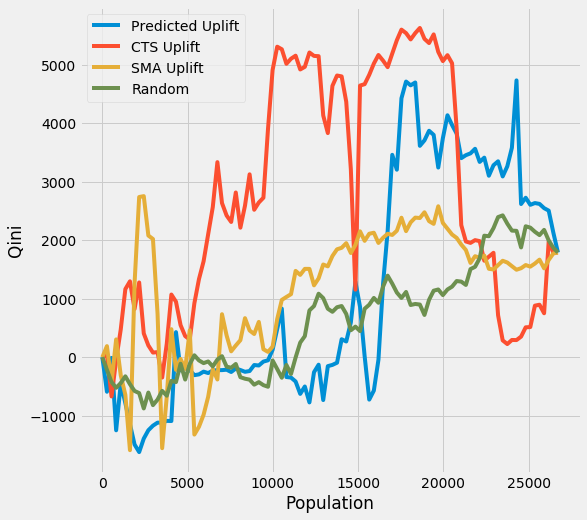

In [258]:
causalml.metrics.plot_qini(table_uplift_nonModified[['Predicted Uplift','CTS Uplift','SMA Uplift',
                                                     "Real Spending",'RealTreatment',
                                                    ]], 
                           outcome_col = "Real Spending",
                           treatment_col = "RealTreatment",
                           n = 100,
                           figsize=(8, 8))

### Gain curve

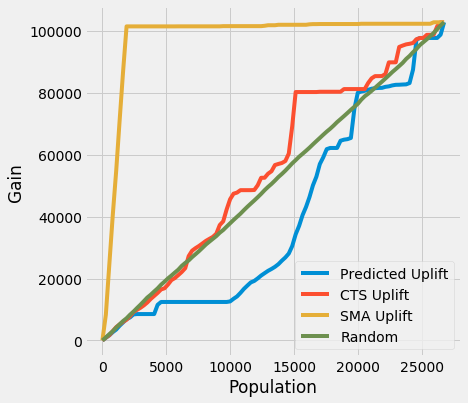

In [259]:
causalml.metrics.plot_gain(table_uplift_nonModified[['Predicted Uplift','CTS Uplift','SMA Uplift',
                                                     "Real Spending"]], 
                           treatment_effect_col = "Real Spending",
                           figsize=(6, 6))

In [260]:
causalml.metrics.auuc_score(table_uplift_nonModified[['Predicted Uplift','CTS Uplift','SMA Uplift',
                                                     "Real Spending",'RealTreatment']], 
                           outcome_col = "Real Spending",
                           treatment_col = "RealTreatment",
                           normalize=False,
                           figsize=(6, 6))

Predicted Uplift    1468.320256
CTS Uplift          3736.207031
SMA Uplift          1558.413523
Random               802.028605
dtype: float64

Text(0, 0.5, 'Cumulative Spend Increase (€)')

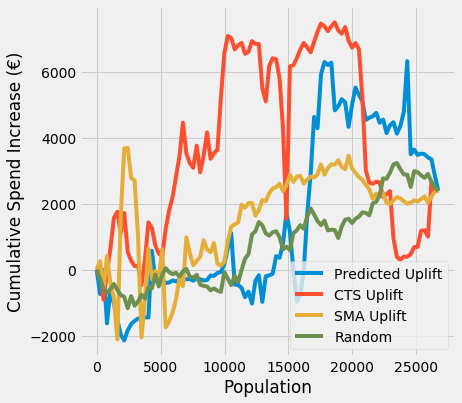

In [264]:
causalml.metrics.plot_gain(table_uplift_nonModified[['Predicted Uplift','CTS Uplift','SMA Uplift',
                                                     "Real Spending",'RealTreatment']], 
                           outcome_col = "Real Spending",
                           treatment_col = "RealTreatment",
                           normalize=False,
                           figsize=(6, 6))
plt.ylabel('Cumulative Spend Increase (€)')

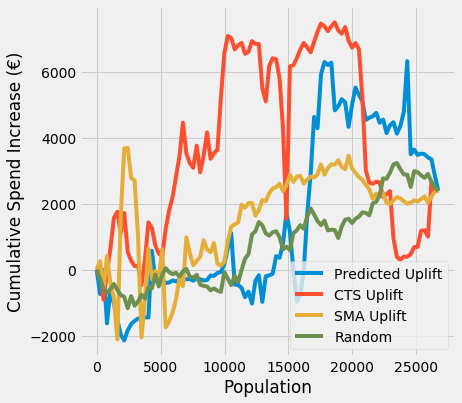

In [278]:
causalml.metrics.plot_gain(table_uplift_nonModified[['Predicted Uplift','CTS Uplift','SMA Uplift',
                                                     "Real Spending",'RealTreatment']], 
                           outcome_col = "Real Spending",
                           treatment_col = "RealTreatment",
                           normalize=False,
                           figsize=(6, 6))
plt.ylabel('Cumulative Spend Increase (€)')
plt.savefig('Evaluation_new.png', transparent=True, bbox_inches='tight')

### Lift Curve

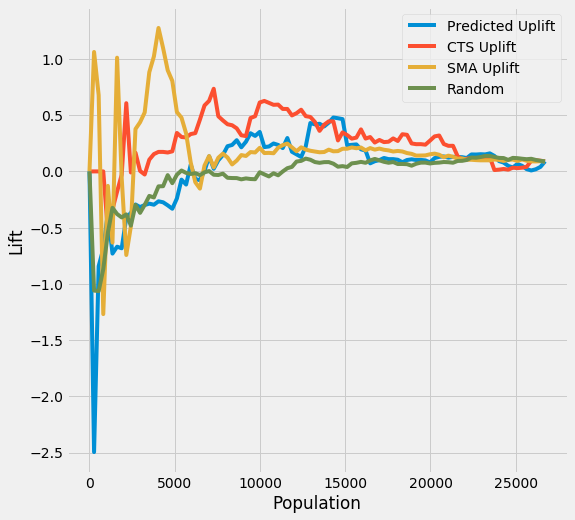

In [105]:
causalml.metrics.plot_lift(table_uplift_nonModified[['Predicted Uplift','CTS Uplift','SMA Uplift',
                                                     "Real Spending",'RealTreatment']], 
                           outcome_col = "Real Spending",
                           treatment_col = "RealTreatment",
                           figsize=(8, 8))

### Modified Uplift Curve

In [106]:
table_uplift

,PredictedTreatment,Predicted Uplift,CTS Uplift,CTS treatment,SMA treatment,SMA Uplift,Real Spending,RealTreatment
0,No Discount,0.000000,0.679275,P_20,No_Discount,0.0,0.0,P_50
1,P_20,20.729873,0.732586,P_20,No_Discount,0.0,0.0,No Discount
2,P_20,14.740390,0.666860,P_20,No_Discount,0.0,0.0,P_20
3,No Discount,0.000000,0.804152,P_20,No_Discount,0.0,0.0,P_50
4,P_20,11.945796,0.821178,P_20,No_Discount,0.0,0.0,P_50
...,...,...,...,...,...,...,...,...
26714,P_75,22.065323,1.179811,P_75,No_Discount,0.0,0.0,P_50
26715,P_20,22.262531,1.641982,P_75,No_Discount,0.0,0.0,P_50
26716,P_25,11.408027,0.794638,P_20,No_Discount,0.0,0.0,P_20
26717,P_25,2.004691,0.665484,P_20,No_Discount,0.0,0.0,No Discount


In [107]:
pd.DataFrame(table_uplift.RealTreatment.value_counts(normalize=True))

,RealTreatment
P_50,0.585164
No Discount,0.251319
P_20,0.082076
P_75,0.075864
P_25,0.005577


In [108]:
tr_prob = pd.DataFrame(table_uplift.RealTreatment.value_counts(normalize=True))['RealTreatment'].to_dict() 
tr_prob['No_Discount'] = 0.25131928590141844   # for SMA
tr_prob

{'P_50': 0.5851641154234815,
 'No Discount': 0.25131928590141844,
 'P_20': 0.08207642501590628,
 'P_75': 0.07586361765036116,
 'P_25': 0.005576556008832666,
 'No_Discount': 0.25131928590141844}

In [109]:
for treatment in tr_prob:
    print(treatment,'{}:'.format(tr_prob[treatment]))


P_50 0.5851641154234815:
No Discount 0.25131928590141844:
P_20 0.08207642501590628:
P_75 0.07586361765036116:
P_25 0.005576556008832666:
No_Discount 0.25131928590141844:


In [110]:
df = table_uplift
outcome_col = "Real Spending"
treatment_col = "RealTreatment"
model = {"PredictedTreatment":"Predicted Uplift","CTS treatment":"CTS Uplift","SMA treatment":"SMA Uplift"}

df = df.copy()
tr_prob = pd.DataFrame(table_uplift.RealTreatment.value_counts(normalize=True))['RealTreatment'].to_dict() 
tr_prob['No_Discount'] = 0.25131928590141844   # for SMA

modified_uplift = []
for treatment in model:
    df = df.sort_values(model[treatment], ascending=False).reset_index(drop=True)
    df.index = df.index + 1
    
    prob = df[treatment].replace(tr_prob)
    df['prob_%s'% (treatment)] = prob
    df['Z_%s'% (treatment)] = 0
    df['Z_%s'% (treatment)][df['RealTreatment']==df[treatment]] = df[model[treatment]]/df['prob_%s'% (treatment)]
    df['Zbar_%s'% (treatment)] = df['Z_%s'% (treatment)].expanding().mean()

    modified_uplift.append(df['Zbar_%s'% (treatment)])

modified_uplift = pd.concat(modified_uplift, join='inner', axis=1)
modified_uplift.loc[0] = np.zeros((modified_uplift.shape[1], ))
modified_uplift = modified_uplift.sort_index()


# modified_uplift
# return lift

df

,PredictedTreatment,Predicted Uplift,CTS Uplift,CTS treatment,SMA treatment,SMA Uplift,Real Spending,RealTreatment,prob_PredictedTreatment,Z_PredictedTreatment,Zbar_PredictedTreatment,prob_CTS treatment,Z_CTS treatment,Zbar_CTS treatment,prob_SMA treatment,Z_SMA treatment,Zbar_SMA treatment
1,P_20,20.778727,1.641982,P_75,P_25,36.6583,29.8,P_50,0.082076,0.000000,21.174724,0.075864,0.000000,1.863742,0.005577,0.0,0.000000
2,P_20,18.301593,1.773431,P_75,P_25,36.6583,35.8,P_50,0.082076,0.000000,21.378471,0.075864,0.000000,1.951021,0.005577,0.0,0.000000
3,No Discount,0.000000,1.773431,P_75,P_25,36.6583,19.9,P_50,0.251319,0.000000,16.328382,0.075864,0.000000,2.256324,0.005577,0.0,0.000000
4,P_20,20.778727,1.773431,P_75,P_25,36.6583,97.8,P_75,0.082076,0.000000,21.092097,0.075864,23.376568,1.949026,0.005577,0.0,0.000000
5,No Discount,0.000000,1.773431,P_75,P_25,36.6583,49.9,P_50,0.251319,0.000000,15.719341,0.075864,0.000000,1.934153,0.005577,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26715,P_20,19.387951,0.852527,P_75,No_Discount,0.0000,0.0,P_50,0.082076,0.000000,21.302699,0.075864,0.000000,1.519443,0.251319,0.0,0.560808
26716,P_20,19.387951,0.852527,P_75,No_Discount,0.0000,0.0,P_50,0.082076,0.000000,21.304517,0.075864,0.000000,1.519608,0.251319,0.0,0.560787
26717,P_20,19.387951,0.852527,P_75,No_Discount,0.0000,0.0,No Discount,0.082076,0.000000,21.306336,0.075864,0.000000,1.519772,0.251319,0.0,0.560766
26718,P_20,19.387951,0.852527,P_75,No_Discount,0.0000,0.0,P_20,0.082076,236.218273,21.308155,0.075864,0.000000,1.519937,0.251319,0.0,0.560745


In [111]:
modified_uplift

,Zbar_PredictedTreatment,Zbar_CTS treatment,Zbar_SMA treatment
0,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000
2,38.453635,0.000000,0.000000
3,25.635757,0.000000,0.000000
4,38.453635,0.000000,0.000000
...,...,...,...
26715,14.860264,1.013265,0.560808
26716,14.859708,1.013227,0.560787
26717,14.859152,1.013189,0.560766
26718,14.858595,1.013151,0.560745


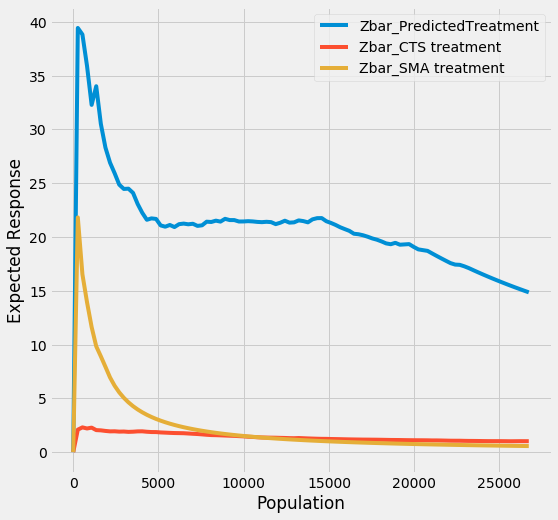

In [112]:
n=100
figsize=(8, 8)
if (n is not None) and (n < df.shape[0]):
    modified_uplift.iloc[np.linspace(0, df.index[-1], n, endpoint=True)].plot(figsize=figsize)
    plt.xlabel('Population')
    plt.ylabel('Expected Response')